This notebook presents an application semi-physical model of the L1 laser in its second version, based on PyTorch.
In particular, in this notebook the optimization process of the control parameters is solved using such a model. 

Author: Francesco Capuano, 2022 S17 summer intern @ ELI-beamlines, Prague


# Motivation

The goal of this project is to maximise second-harmonic efficiency. However, since this metric is also very much related to the shortest possible pulse shape, we started with developing a strategy to optimise a predefinite set of control parameters so as to minimise the difference between the obtained pulse shape (in the temporal domain) and a target one (which, by default, is the shortest one typically). 

However, since data are really expensive to empirically collect we resorted to model the underlying dynamics of the whole system, also considering that (even if not exhaustive) there is a significant amount of know-how concerned with the considered dynamics available.

After this model is obtained, it is possible to use it to obtain the desired control parameters.

In [1]:
import torch
# these import are necessary to import modules from directories one level back in the folder structure
import sys
sys.path.append("../..")
from utils.se import get_project_root
from algorithms.L1_BayesianOptimisation import extract_data
import matplotlib.pyplot as plt
from scipy.optimize import Bounds
import numpy as np

frequency, field = extract_data()

C:\Users\Ext_Capuano\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The preprocessing steps do not depend on the control parameters, therefore they can take place even in numpy

In [2]:
# preprocessing steps
from utils.physics import *
# preprocessing
cutoff = np.array((289.95, 291.91)) * 1e12
# cutting off the signal
frequency_clean, field_clean = cutoff_signal(frequency_cutoff = cutoff, frequency = frequency * 1e12,
                                             signal = field)
# augmenting the signal
frequency_clean_aug, field_clean_aug = equidistant_points(frequency = frequency_clean,
                                                          signal = field_clean,
                                                          num_points = int(3e3)) # n_points defaults to 5e3
# retrieving central carrier
central_carrier = central_frequency(frequency = frequency_clean_aug, signal = field_clean_aug)

However, to be used in the Computational Laser model, their tensor version is required

In [3]:
from utils.LaserModel_torch import ComputationalLaser as CL

intensity = torch.from_numpy(field ** 2)
frequency, field = torch.from_numpy(frequency_clean_aug), torch.from_numpy(field_clean_aug)
compressor_params = -1 * torch.tensor([267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50], dtype = torch.double)

laser = CL(frequency = frequency * 1e-12, field = field, compressor_params = compressor_params)

In [4]:
from utils.LaserOpt import LaserOptimization, optimization
lOpt = LaserOptimization(laser).to("cuda") if torch.cuda.is_available() else LaserOptimization(laser)

Pytorch offers various optimizers which are normally considered to be very well suited in NN. However, with a slight tweak and flexibility of reasoning, they can be applied to this very problem as well, as long as this very problem is actually formulated as one of those Pytorch optimizers are meant to solve. 

In [5]:
torch.cuda.empty_cache()

In [6]:
from torch.optim import Adam
# SGD optimizers applied to the considered problem in the considered setting
opt = Adam(lOpt.parameters(), lr = 1e-3)
# start optimization process
losses, best_candidate = optimization(lOpt, opt, maxit = int(1e5))

Iteration 100000 100000: 100%|█████████████████████████████████████████████████| 100000/100000 [17:32<00:00, 95.03it/s]


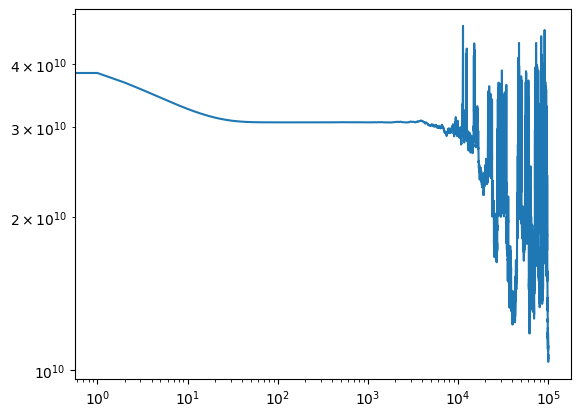

In [7]:
plt.plot(losses)
plt.yscale("log")
plt.xscale("log")